### Imports

If working in a [suite2p](https://github.com/MouseLand/suite2p) conda environment initialized according to the guide [here](https://github.com/MouseLand/suite2p#installation), using the provided [environment.yml](https://github.com/MouseLand/suite2p/blob/main/environment.yml), all of these dependencies should all be present, with the exception of `skimage`. To obtain it, execute `conda install scikit-image` in your terminal while your **suite2p** conda environment is active. 

Pytorch, and another repository of mine are now also dependencies, but they are only used toward the end after the PCA section in some experimental clustering attempts. These cells can be commented out (along with the dependencies if you want to use this notebook and not set those up).

In [1]:
import os
import re
import shutil
import sys
from datetime import date
from copy import deepcopy

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle

from skimage import io
from skimage import measure
from tifffile import imsave

from scipy import signal
from scipy.interpolate import interp2d
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import cluster

# local imports
from image_arrays import *
from s2p_packer import unpack_hdf
from fitting import BiexpFitter

sys.path.append('../python-analysis')
import torch_clustering as clorch
import cluster_ae_builds as builds
from conv1d_deep_cluster import Conv1dDeepClusterer

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

### Paths describing folder structure used for loading in videos and data archives
These, along with naming of the files when they come up, should be altered to align with your setup.

In [3]:
base_path = "/mnt/Data/prerna_noise/"
data_path = os.path.join(base_path, "2022_04_27_32bit_2f_processed_4x4/")
depth_path = os.path.join(data_path,"DD/")

# ex_name = "400um"
# tiff_path = os.path.join(depth_path, ex_name)
tiff_path = depth_path
noise_path = os.path.join(data_path, "noise")

### Load noise stimulus
Here it is expected to be in `base_path`. Also, create an upsampled version (not currently in use, could be commented out).

In [4]:
raw_noise = np.stack(
    [
        io.imread(os.path.join(noise_path, f))
        for f in os.listdir(noise_path) 
        if (f.endswith(".tiff") or f.endswith(".tif"))
    ], 
    axis=0
)
raw_noise = np.squeeze(raw_noise) / 255
raw_noise = raw_noise.transpose(0, 2, 1)
# raw_noise = np.rot90(raw_noise, k=2, axes=(1, 2))
raw_noise = np.flip(raw_noise, axis=1)
raw_noise = np.flip(raw_noise, axis=2)

# physical dimensions (microns)
stim_width = 400
stim_height = 400

# 60Hz after 10s delay
noise_frames, noise_cols, noise_rows = raw_noise.shape
noise_xaxis = np.arange(noise_frames) * (1 / 60) + 10.

print("raw noise shape:", raw_noise.shape)

raw noise shape: (7200, 16, 16)


### Display noise stimulus used for this experiment / analysis
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`).

<IPython.core.display.Javascript object>


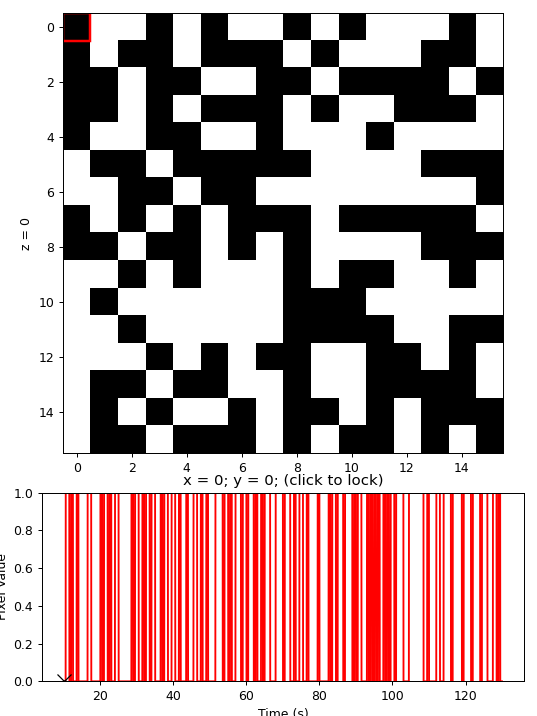

In [5]:
raw_noise_plot = StackExplorer(
    raw_noise,
    zaxis=noise_xaxis,
    delta=10,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
raw_noise_plot.ax[1].set_xlabel("Time (s)")
raw_noise_plot.ax[1].set_ylabel("Pixel Value")

raw_noise_plot.fig.show()

<IPython.core.display.Javascript object>


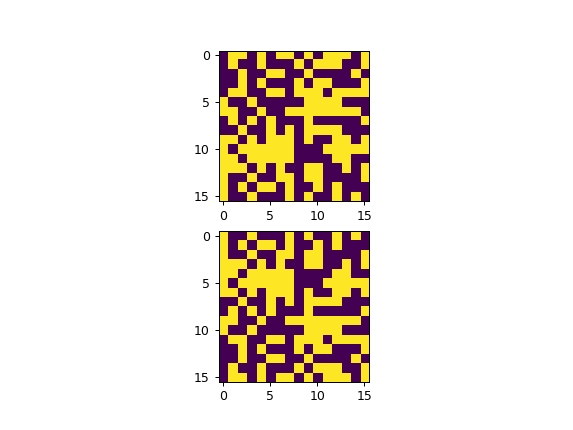

In [6]:
fff, aaa = plt.subplots(2)
aaa[0].imshow(raw_noise[0])
aaa[1].imshow(np.flip(raw_noise[0], 0))

### List tiff files found in the directory indicated by `tiff_path`

#### Note:
**DD ->** distal. **X** 71.7um, **Y** 28.94um

**PD ->** proximal. **X** 71.7um, **Y** 30.9um

In [7]:
fnames = [
    f for f in os.listdir(tiff_path) 
    if (f.endswith(".tiff") or f.endswith(".tif"))
]

print("files:")
for f in fnames:
    print("  %s" % f)

files:


### Select (and display) recording to analyse here.
Set `ex_name` to the name shared by the desired `.tif` (found in `data_path`) and the `.h5` (found in `s2p_path`). Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`). While moving around the ROI, one may left-click to lock it in the current position, allowing interaction with the z-projection axis underneath.

In [8]:
hz = 58.25
dt = 1 / hz

# stacks = np.stack(
#     [
#         io.imread(os.path.join(tiff_path, f))
#         for f in os.listdir(tiff_path) 
#         if (f.endswith(".tiff") or f.endswith(".tif"))
#     ],
#     axis=0
# )
# stacks = stacks[:2]

def unpack(pth):
    with h5.File(pth) as f:
        data = unpack_hdf(f)["stack"]
    return data

stacks = np.stack(
    [
        unpack(os.path.join(tiff_path, f))
        for f in os.listdir(tiff_path) 
        if f.endswith(".h5")
    ],
    axis=0
)

n_trials, n_pts, stack_rows, stack_cols = stacks.shape
mean_stack_proj = np.mean(stacks, axis=(0, 1))

recs_xaxis = np.arange(n_pts) * dt
stim_start_idx = nearest_index(recs_xaxis, noise_xaxis.min())
stim_end_idx = nearest_index(recs_xaxis, noise_xaxis.max())

##### physical dimensions (in microns)
# width and height kept from full scan field (cropped in preprocessing)
x_crop_ratio = (stack_cols - (16 / 4)) / stack_cols
y_crop_ratio = 1.

rec_width = 164.54 *  x_crop_ratio
rec_height = 80.42 * y_crop_ratio
rec_x_offset = -0.64273
rec_y_offset = -7.226

print("stacks shape:", stacks.shape)

stacks shape: (3, 8000, 64, 56)


### Dynamic ROI plot of recordings
Trial to display in the stack axis can be selected with the slider, with the last position being the average. Use mouse scroll to cycle through frames of the movies. Beams of the outlined ROI are displayed below with the current trial highlighted in red. The average beam is displayed with a thicker linewidth and greater opacity.

**NOTE:** If the recordings are large, this will use up a lot of RAM.

<IPython.core.display.Javascript object>


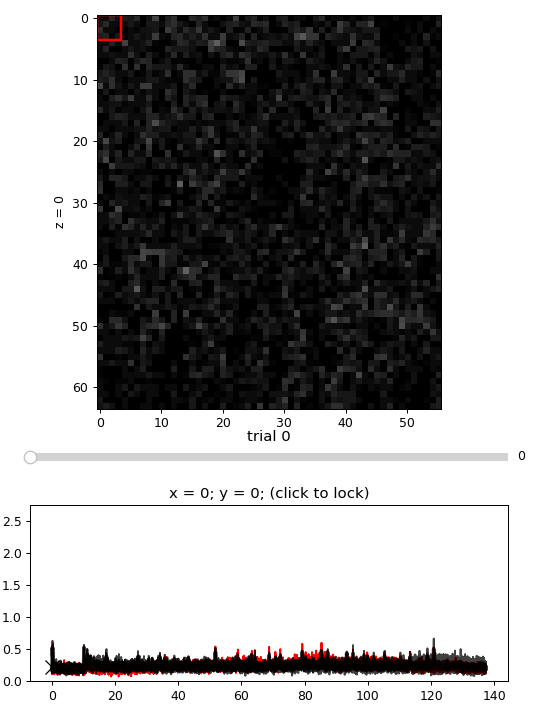

Recording shape: (8000, 64, 56)


In [9]:
stacks_plot = StackExplorer(
    stacks,
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=4,
    vmin=0,
    figsize=(6, 8)
)
stacks_plot.ax[1].set_xlabel("Time (s)")
stacks_plot.ax[1].set_ylabel("Pixel Value")

print("Recording shape:", stacks[0].shape)
stacks_plot.fig.show()

### Grid ROI placement using Quality Index acceptance threshold
Take `grid_w` by `grid_h` beams from the scan field and discard those that do not meet the `min_qi` threshold.

In [10]:
# grid_w = 20
# grid_h = 16
grid_w = 4
grid_h = 4
# grid_w = 8
# grid_h = 8
grid_cols = stack_cols // grid_w
grid_rows = stack_rows // grid_h
col_x = rec_width / stack_cols
row_y = rec_height / stack_rows

# min_qi = .5
min_qi = 0.

i = 0
grid_recs, grid_locs, all_qis, accepted_qis, grid_idxs = [[] for _ in range(5)]
for x0 in range(0, stack_cols, grid_w):
    for y0 in range(0, stack_rows, grid_h):
        beams = np.mean(stacks[:, :, y0:y0 + grid_h, x0:x0 + grid_w], axis=(2, 3))
        qi = quality_index(beams[:, stim_start_idx:stim_end_idx])
        all_qis.append(qi)
        if qi > min_qi:
            grid_recs.append(beams)
            grid_locs.append([x0, y0])
            accepted_qis.append(qi)
            grid_idxs.append(i)
        i += 1

grid_recs = np.stack(grid_recs, axis=1)
avg_grid_recs = np.mean(grid_recs, axis=0)
grid_locs = np.stack(grid_locs, axis=0)
print("number of grid ROIs accepted:", grid_recs.shape[1])

number of grid ROIs accepted: 224


### Quality Index distribution and accepted ROI map
Histogram includes the entire distribution of QIs, while the plot below highlights the locations of the passable QI ROIs in space. Red squares with red QI indicate ROIs that have been accepted, white values correspond to ROIs that did not reach the quality index threshold `min_qi`.

<IPython.core.display.Javascript object>


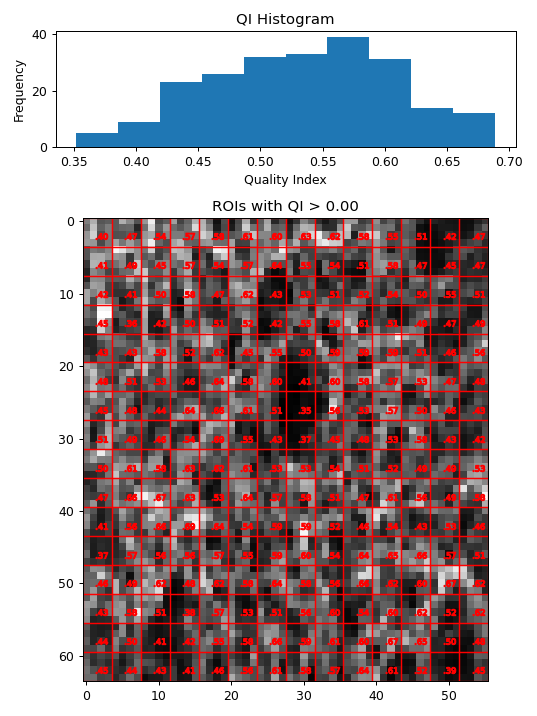

In [11]:
half_w = grid_w / 2
half_h = grid_h / 2
grid_fig, grid_ax = plt.subplots(
    2, 
    gridspec_kw={"height_ratios": [.2, .8]}, 
    figsize=(6, 8)
)

grid_ax[0].hist(all_qis)
grid_ax[0].set_title("QI Histogram")
grid_ax[0].set_xlabel("Quality Index")
grid_ax[0].set_ylabel("Frequency")

grid_ax[1].imshow(mean_stack_proj, cmap="gray")
grid_ax[1].set_title("ROIs with QI > %.2f" % min_qi)

for (x, y) in grid_locs:
    grid_ax[1].add_patch(
        Rectangle(
            (x - .5, y - .5),  # grid offset
            grid_w, 
            grid_h, 
            fill=False,
            color="red",
            linewidth=1,
            linestyle="-"
        )
    )

i = 0
for x0 in range(0, stack_cols, grid_w):
    for y0 in range(0, stack_rows, grid_h):
        grid_ax[1].scatter(
            x0 + half_w,
            y0 + half_h, 
            marker="$%s$" % ("%.2f" % all_qis[i]).lstrip("0"), 
            s=100,
            c="red" if all_qis[i] > min_qi else "1",
        )
        i += 1
        
grid_fig.tight_layout()

### Denoise and signal-noise normalize ROI responses

In [12]:
# grid_recs /= np.var(grid_recs[:, :, 40:198], axis=2).reshape(*grid_recs.shape[:2], 1)
# grid_recs -= np.mean(grid_recs[:, :, 40:198], axis=2).reshape(*grid_recs.shape[:2], 1)
# avg_grid_recs /= np.var(avg_grid_recs[:, 40:198], axis=1).reshape(avg_grid_recs.shape[0], 1)
# avg_grid_recs -= np.mean(avg_grid_recs[:, 40:198], axis=1).reshape(avg_grid_recs.shape[0], 1)
grid_recs /= np.var(grid_recs[:, :, -200:], axis=2).reshape(*grid_recs.shape[:2], 1)
grid_recs -= np.mean(grid_recs[:, :, -200:], axis=2).reshape(*grid_recs.shape[:2], 1)
avg_grid_recs /= np.var(avg_grid_recs[:, -200:], axis=1).reshape(avg_grid_recs.shape[0], 1)
avg_grid_recs -= np.mean(avg_grid_recs[:, -200:], axis=1).reshape(avg_grid_recs.shape[0], 1)

In [13]:
tau1 = 2 # rise [ms]
# tau2 = 30  # decay [ms]
tau2 = 40  # decay [ms]
quantum_pts = 100

fitter = BiexpFitter(1, 10, norm_amp=True)
biexp_quantum = fitter.model(
    t=np.arange(quantum_pts), 
    tau1=tau1 / 1000 / dt, # convert to match resulting sample-rate to data
    tau2=tau2 / 1000 / dt, 
    y0=1.,
)[0]
biexp_xaxis = np.arange(quantum_pts) * dt

template = biexp_quantum / biexp_quantum.max()
template = np.concatenate([np.zeros(quantum_pts), template])
template = np.flip(template)

grid_conv = map_axis(lambda a: np.convolve(a, template, mode="same"), grid_recs)
avg_grid_conv = map_axis(lambda a: np.convolve(a, template, mode="same"), avg_grid_recs)
detrend_conv = map_axis(lambda a: a - rolling_average(a, n=120), grid_conv)
avg_detrend_conv = map_axis(lambda a: a - rolling_average(a, n=120), avg_grid_conv)

# detrend_conv = detrend_conv / detrend_conv.max(axis=2, keepdims=True)

In [14]:
grid_conv.shape

(3, 224, 8000)

### Explore signals from ROIs, and peak finding parameters
Use scroll wheel to cycle between ROIs, and the input boxes below to
adjust parameters for the peak finding algorithm (see `scipy.signal.find_peaks` for more documentation).

- **prominence:** target difference between a peak and its surrounding mean
- **width:** number of points the value must remain within the fractional **tolerance** range of the peak in order to be considered
- **distance:** minimum allowable interval between peak candidates

<IPython.core.display.Javascript object>


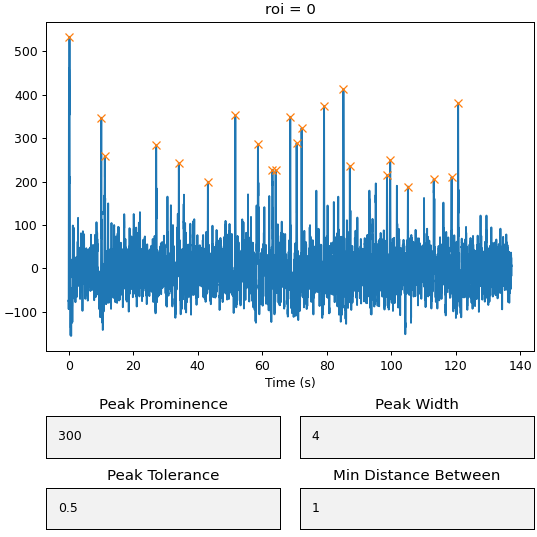

In [15]:
peak_explorer = PeakExplorer(
    recs_xaxis, 
#     grid_recs[0],
#     avg_grid_recs,
#     grid_conv[0],
    detrend_conv[0],
    prominence=300,
    width=4,
    tolerance=.5,
    distance=1
)

### Create response triggered average of stimulus movie, and use a rough transformation of the cell ROI to calculate the average intensity over time.
- `roi_idx` sets the ROI used to generate the triggered stimulus. Make use of the mask and beam scrollers above to pick out ROIs that you might want to do this with
- `lead` sets the time (in seconds) to use preceding each threshold passing event.
- peak finding parameters correspond to those above, set them here in order to influence the stimulus triggered window calculation.
- `max_prominence` sets a clip off point for peaks, such that errantly large events do not completely wash out the rest (due to prominence scaling using softmax). This is optional, and can be set to `None` or commented out from the arguments given to `avg_trigger_window`.

The dotted blue outline represents the relative postion and size of the recording scan field. This can be removed by simply changing the value in the conditional to `0` (or `False`). 

In [16]:
grid_mode = True

lead = 8.             # length of triggered average movie (seconds before peak)
post = 5.
prominence = 280       # difference between peaks and their surroundings
peak_width = 4         # minimum number of points (within tolerance)
peak_tolerance = .6    # ratio value can drop from peak within width
min_peak_interval = 1  # number of points required between peaks
max_prominence = 4     # clip to avoid dominance by errant peaks
start_time = 30        # time to begin using peaks for triggered average
end_time = None        # cutoff time for considering peaks
min_peak_count = 20    # ROIs with fewer peaks are thrown out
# min_peak_count = 0    # ROIs with fewer peaks are thrown out

lead_xaxis = trigger_xaxis(noise_xaxis, lead, post)
lead_frames = len(lead_xaxis)

# NOTE: ROIs to do not meet `min_peak_count` will be thrown out, so pos_to_roi 
# must be used from here on for lining up ROI numbers with the index in
# lead_stacks and derived arrays
lead_stacks, legal_times = [], []
count, pos_to_roi, roi_to_pos = 0, [], {}

# add avg_recs to end, then split out the results to decrease duplication
# combined_recs = np.concatenate([grid_recs, np.expand_dims(avg_grid_recs, 0)], axis=0)
# combined_recs = np.concatenate([grid_conv, np.expand_dims(avg_grid_conv, 0)], axis=0)
combined_recs = np.concatenate([detrend_conv, np.expand_dims(avg_detrend_conv, 0)], axis=0)
    
for i in range(combined_recs.shape[1]): 
    peak_idxs, peak_proms = find_peaks(
        combined_recs[:, i],
        prominence=prominence,
        width=peak_width,
        rel_height=peak_tolerance,
        distance=min_peak_interval
    )
        
    windows, legals = [], []
    for j in range(combined_recs.shape[0]):
        trig, times = avg_trigger_window(
            noise_xaxis, 
            raw_noise,
            recs_xaxis,
            lead,
            post,
            peak_idxs[j],
            prominences=peak_proms[j],
#             prominences=None,
            max_prominence=max_prominence,
            nonlinear_weighting=True,
            start_time=start_time,
            end_time=end_time,
        )
        windows.append(trig)
        legals.append(times)
        
    # rois with trials without triggers are dropped (lookups track the gaps)
    if all(map(lambda l: len(l) > min_peak_count, legals[:-1])):
        lead_stacks.append(np.stack(windows, axis=0))
        legal_times.append(legals)
        pos_to_roi.append(i)
        roi_to_pos[i] = count
        count += 1
        
del combined_recs
        
# split trial and average output
avg_lead_stacks = np.stack([l[-1] for l in lead_stacks], axis=0)
lead_stacks = np.stack([l[:-1] for l in lead_stacks], axis=0)
avg_legal_times = [l[-1] for l in legal_times]
legal_times = [l[:-1] for l in legal_times]

# shape of lead_stacks is [n_kept_rois, n_trials, lead_frames, n_cols, n_rows]
mean_lead_stacks = np.mean(lead_stacks, axis=1)
all_roi_lead_stack = np.mean(lead_stacks, axis=0)
n_kept_rois = len(pos_to_roi)
thrown = (grid_recs.shape[1] if grid_mode else n_rois) - n_kept_rois
print("number of ROIs thrown out:", thrown)
print("ROIs remaining:", n_kept_rois)
print("lead_stacks shape:", lead_stacks.shape)

number of ROIs thrown out: 54
ROIs remaining: 170
lead_stacks shape: (170, 3, 780, 16, 16)


### Show locations and indices of remaining grid ROIs (if in `grid_mode`)
The indices displayed below correspond to the `grid_recs` array, which holds all of the grid ROI beams that passed the initial quality check. Not all of them are represented here, as some ROIs are thrown out at the peak detection stage before calculating triggered stimuli. As down elsewhere, the `pos_to_roi` lookup list is used to translated the position/index in the set of "kept" ROIs to the ROIs found in the `grid_recs` array (which have undergone selection previously, thus the gaps in numbering)

<IPython.core.display.Javascript object>


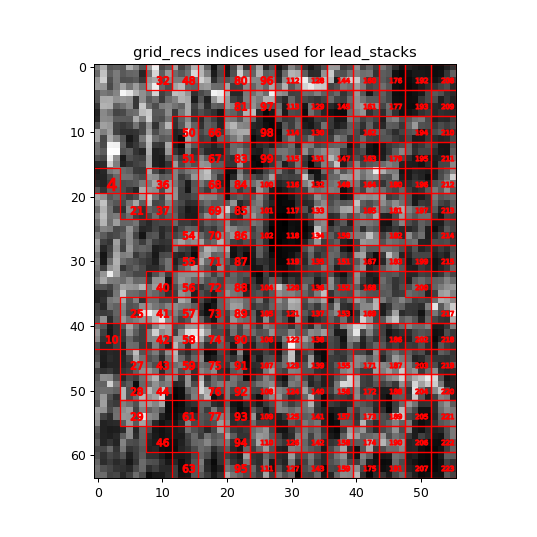

In [17]:
if grid_mode:
    grid_idx_fig, grid_idx_ax = plt.subplots(1, figsize=(6, 6))
    grid_idx_ax.imshow(mean_stack_proj, cmap="gray")
    grid_idx_ax.set_title("grid_recs indices used for lead_stacks")

    for i, (x, y) in enumerate(grid_locs[pos_to_roi]):
        grid_idx_ax.add_patch(
            Rectangle(
                (x - .5, y - .5),  # grid offset
                grid_w, 
                grid_h, 
                fill=False,
                color="red",
                linewidth=1,
                linestyle="-"
            )
        )
        grid_idx_ax.scatter(
            x + half_w,
            y + half_h, 
            marker="$%i$" % pos_to_roi[i], 
#             marker="$%i$" % grid_idxs[i], 
            s=100,
            c="red",
        )

<IPython.core.display.Javascript object>


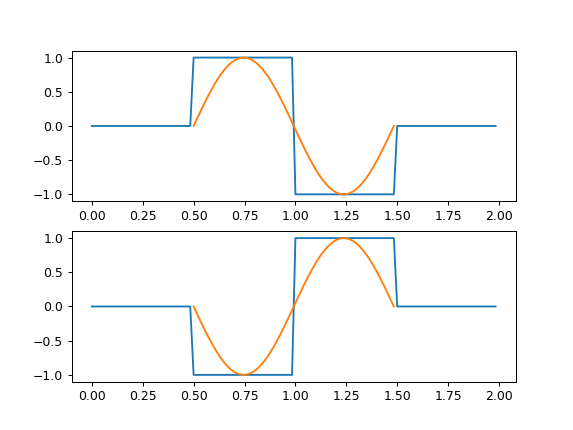

In [18]:
noise_freq = 2.
kernel_frames = int(60. / noise_freq)
# reversed to work as intended with convolve
kernel_ones = np.ones(kernel_frames)
kernel_zeros = np.zeros(kernel_frames)
decrement = np.concatenate([kernel_ones * -1., kernel_ones])
increment = np.concatenate([kernel_ones, kernel_ones * -1.])
decr_sin = np.sin(np.linspace(-np.pi, np.pi, kernel_frames * 2))
incr_sin = np.flip(decr_sin)
decr_sin_cycle = np.concatenate([kernel_zeros, decr_sin, kernel_zeros])
incr_sin_cycle = np.flip(decr_sin_cycle)
decrement_cycle = np.concatenate([kernel_zeros, decrement, kernel_zeros])
increment_cycle = np.concatenate([kernel_zeros, increment, kernel_zeros])
contrast_filter_fig, contrast_filter_ax = plt.subplots(2)
contrast_filter_ax[0].plot(np.arange(len(increment_cycle)) * (1. / 60.), increment_cycle)
contrast_filter_ax[0].plot(np.arange(len(incr_sin)) * (1. / 60.) + 0.5, incr_sin)
contrast_filter_ax[1].plot(np.arange(len(decrement_cycle)) * (1. / 60.), decrement_cycle)
contrast_filter_ax[1].plot(np.arange(len(decr_sin)) * (1. / 60.) + 0.5, decr_sin)

In [19]:
def trigger_stim_conv(kernel):
    def f(mov):
        shape = mov.shape
        mov = mov.transpose(1, 2, 0)
        mov = map_axis(lambda a: np.convolve(a, kernel, mode="same"), mov)
        return mov.transpose(2, 0, 1)
    return f

lead_stacks_conv = map_axis(
#     trigger_stim_conv(increment_cycle / len(increment_cycle)),
#     trigger_stim_conv(decrement_cycle / len(decrement_cycle)),
    trigger_stim_conv(incr_sin / len(incr_sin)),
    lead_stacks - 0.5,
    axis=2
)

## TODO:
- sanity check on ROI idx lookup schemes. Would like to make sure that I am being consistent
- noticed that the stacks are displaying as taller than they are wide, despite the dimensions of the scan field. Ensure everything is transposed where appropriate to have the physical space properly represented
  - actually, since the recordings are 256x256, the diminished width is just from my cropping during preprocessing. So the orientation should be preserved I think...
- make sure that the dropped ROI filling and stack reconstruction is being done correctly. The presence of the T shape with the current QI is correct, but the corners don't seem right to me.
- some of the code blocks have accumulated functionality that should probably be collected into helper functions and moved into modules. Having it abstracted away will mean less propagating fixes manually across duplicate notebooks for different datasets
- think about new helpers to facilitate comparison of different/specific ROIs with eachother (are the receptive fields similar as they should be etc)
- convolve triggered stimuli kernels to highlight contrast increment and decrements. This might help to draw out "centre" and "surround" fields better 

<IPython.core.display.Javascript object>


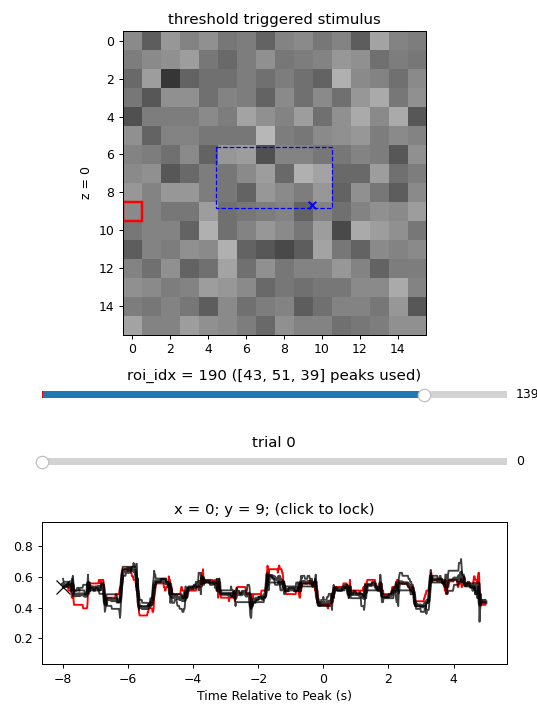

In [20]:
def roi_fmt_fun(i):
    n_legals = [len(l) for l in legal_times[i]]
    return "roi_idx = %i (%s peaks used)" % (pos_to_roi[i], str(n_legals) )

lead_stack_plot = StackExplorer(
    lead_stacks,
#     lead_stacks_conv,
    zaxis=lead_xaxis,
    delta=2,
    roi_sz=1,
#     vmin=0,
#     vmax=1,
    n_fmt_fun=roi_fmt_fun,
    figsize=(6, 8)
)
lead_stack_plot.stack_ax.set_title("threshold triggered stimulus")
lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
lead_stack_plot.fig.tight_layout()

# outline of scan field (guide for where to look for receptive field)
# NOTE: PD scans are offset (stims is centered to DD scan field)
x_corner_phys = (stim_width - rec_width) / 2 + rec_x_offset
y_corner_phys = (stim_height - rec_height) / 2 + rec_y_offset
x_corner_scaled = x_corner_phys / stim_width * raw_noise.shape[2]
y_corner_scaled = y_corner_phys / stim_height * raw_noise.shape[1]

def scan_field_rect():
    return Rectangle(
        (x_corner_scaled - .5, y_corner_scaled - .5),  # grid offset
        rec_width / stim_width * raw_noise.shape[2], 
        rec_height / stim_height * raw_noise.shape[1], 
        fill=False,
        color="blue",
        linewidth=1,
        linestyle="--"
    )

def update_roi_mark(mark):
    def f(i):
        idx = pos_to_roi[int(i)]
        x, y = grid_locs[idx]
        x = (x * col_x + x_corner_phys) / stim_width * raw_noise.shape[2] - 0.25
        y = (y * row_y + y_corner_phys) / stim_height * raw_noise.shape[1] - 0.25
        mark.set_offsets([[x, y]])
    return f

lead_stack_plot.ax[0].add_patch(scan_field_rect())
lead_roi_mark = lead_stack_plot.ax[0].scatter([0], [0], marker="x", c="blue")
update_roi_mark(lead_roi_mark)(0)    
lead_stack_plot.n_slider.on_changed(update_roi_mark(lead_roi_mark))

lead_stack_plot.fig.show()
#104
# roi 190 x11 y5 (transposed, flipped on axis = 2)
# roi 190 x6 y15 (check post 0 time after shift)

### Triggered Stimulus calculated from average recording
Repeat of above, but using the average of the recordings to determing peak/event timings, rather than individual trials (with subsequent averaging of the triggered stimuli).

<IPython.core.display.Javascript object>


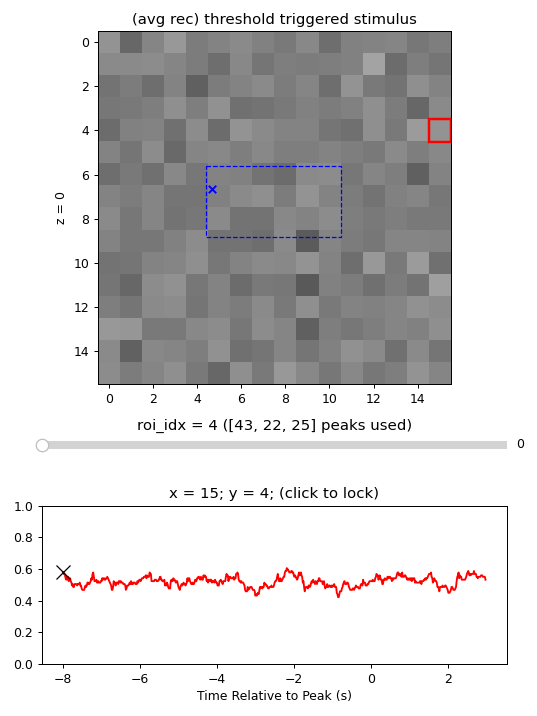

In [21]:
avg_lead_stack_plot = StackExplorer(
    np.expand_dims(avg_lead_stacks, 1),
    zaxis=lead_xaxis,
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=1,
    n_fmt_fun=roi_fmt_fun,
    figsize=(6, 8)
)
avg_lead_stack_plot.stack_ax.set_title("(avg rec) threshold triggered stimulus")
avg_lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
avg_lead_stack_plot.fig.tight_layout()

avg_lead_stack_plot.ax[0].add_patch(scan_field_rect())
avg_lead_roi_mark = avg_lead_stack_plot.ax[0].scatter([0], [0], marker="x", c="blue")
update_roi_mark(avg_lead_roi_mark)(0)    
avg_lead_stack_plot.n_slider.on_changed(update_roi_mark(avg_lead_roi_mark))
avg_lead_stack_plot.fig.show()

In [38]:
start_idx = int(30 * hz)
roi_recs = avg_grid_recs[:, start_idx:]

def fill_grid(rs):
    total_cells = grid_rows * grid_cols
    if rs.shape[0] < total_cells:
        temp, last_i, blank = [], 0, np.zeros(rs.shape[-1])
        for i, r in zip(grid_idxs, rs):
            for j in range(max(i - last_i - 1, 0)):
                temp.append(blank)
            temp.append(r)
            last_i = i
            
        for j in range(total_cells - len(temp)):
            temp.append(blank)
            
        return np.stack(temp, axis=0)
    else:
        return rs[:]

fill_recs = fill_grid(roi_recs)
fill_conv = fill_grid(avg_grid_conv[:, start_idx:])
# fill_recs = signal.detrend(fill_recs)
# fill_recs = np.stack([r - r.mean() for r in fill_recs], axis=0)
n_pts = fill_recs.shape[-1] 

prominence = 300
peak_width = 4
peak_tolerance = .5
min_peak_interval = 1
min_peak_count = 5

lead_time = 0.5
post_time = 0.5

windows = []
for i in range(fill_conv.shape[0]): 
    peak_idxs, _ = find_peaks(
        fill_conv[i],
        prominence=prominence,
        width=peak_width,
        rel_height=peak_tolerance,
        distance=min_peak_interval
    )
        
    trig, _ = avg_trigger_window(
        np.arange(n_pts) * dt, 
        fill_recs.reshape(grid_cols, grid_rows, -1).transpose(2, 1, 0),
        np.arange(n_pts) * dt,
        lead_time,
        post_time,
        peak_idxs,
        prominences=None,
    )
    windows.append(trig)

trigged_stack = np.stack(windows, axis=0)    
del windows

/home/geoff/git/imaging-utils/image_arrays.py:722: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  times = rec_t[(trigger_idxs)]


<IPython.core.display.Javascript object>


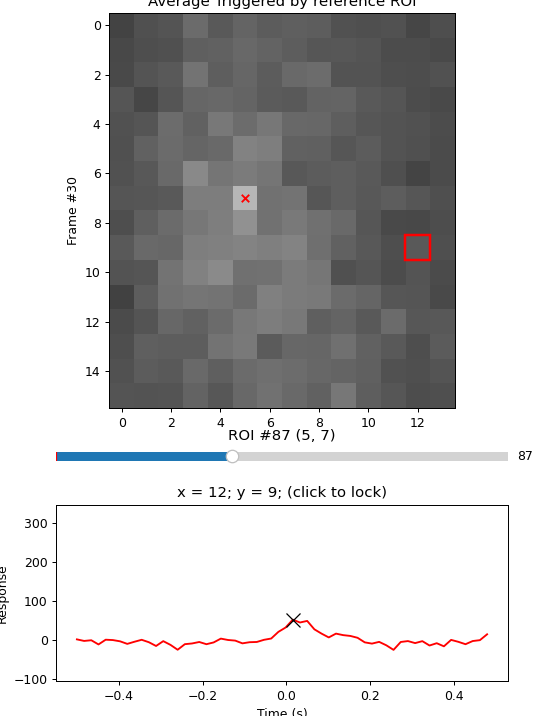

Text(0.5, 1.0, 'Average Triggered by reference ROI')

In [20]:
event_xaxis = np.arange(trigged_stack.shape[1]) * (1 / hz)

triggered_stack_plot = StackExplorer(
    np.expand_dims(trigged_stack - trigged_stack.mean(axis=1, keepdims=True), 1),
    zaxis=(event_xaxis - lead_time),
    delta=1,
    roi_sz=1,
    auto_roi_scale=False,
    z_fmt_fun=(lambda i: "Frame #%i" % i),
    n_fmt_fun=lambda i: "ROI #%i (%i, %i)" % (i, i // grid_rows, i % grid_rows),
    figsize=(6, 8)
)
triggered_stack_plot.ax[2].set_xlabel("Time (s)")
triggered_stack_plot.ax[2].set_ylabel("Response")
triggered_roi_mark = triggered_stack_plot.ax[0].scatter([0], [0], marker="x", c="red")
triggered_stack_plot.n_slider.on_changed(
    lambda v: triggered_roi_mark.set_offsets([[v // grid_rows, v % grid_rows]]))

triggered_stack_plot.ax[0].set_title("Average Triggered by reference ROI")

### Rough "receptive field" map via response vs baseline subtraction
Set baseline and response windows in terms of `lead_xaxis`. Subtractions for all trials, as well as averages will be calculated and displayed in an interactive plot. Use mouse scroll to cycle between ROIs.

<IPython.core.display.Javascript object>


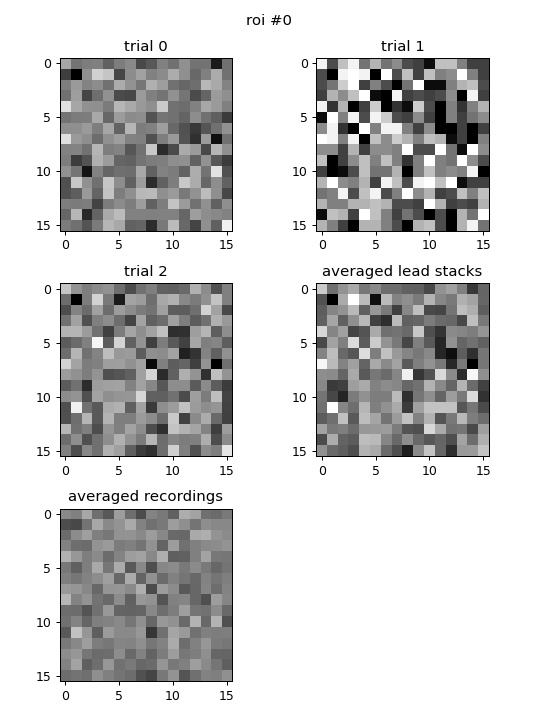

In [28]:
# bsln_t0 = -.500
# bsln_t1 = -.400
# resp_t0 = -.250
# resp_t1 = -.150

bsln_t0 = -.600
bsln_t1 = -.300
resp_t0 = -.250
resp_t1 = 0

# bsln_t0 = -.200
# bsln_t1 = -.150
# resp_t0 = -.75
# resp_t1 = -.25

# bsln_t0 = -.400
# bsln_t1 = -.350
# resp_t0 = -.150
# resp_t1 = -.100

bsln_mask = (bsln_t0 <= lead_xaxis) * (lead_xaxis <= bsln_t1)
bsln = np.mean(lead_stacks[:, :, bsln_mask], axis=2)
resp_mask = (resp_t0 <= lead_xaxis) * (lead_xaxis <= resp_t1)
resp = np.mean(lead_stacks[:, :, resp_mask], axis=2)

sub = resp - bsln
vmin = np.min(sub)
vmax = np.max(sub)

mean_lead_bsln = np.mean(mean_lead_stacks[:, bsln_mask], axis=1)
mean_lead_resp = np.mean(mean_lead_stacks[:, resp_mask], axis=1)
mean_lead_sub = mean_lead_resp - mean_lead_bsln

avg_lead_bsln = np.mean(avg_lead_stacks[:, bsln_mask], axis=1)
avg_lead_resp = np.mean(avg_lead_stacks[:, resp_mask], axis=1)
avg_lead_sub = avg_lead_resp - avg_lead_bsln

n_trials = sub.shape[1]
def title_fun(i):
    if i < n_trials:
        return "trial %i" % i
    elif i == n_trials:
        return "averaged lead stacks"
    elif i == n_trials + 1:
        return "averaged recordings"

sub_field_plotter = MultiStackPlotter(
    np.concatenate(
        [sub, np.expand_dims(mean_lead_sub, 1), np.expand_dims(avg_lead_sub, 1)],
        axis=1,
    ).transpose(1, 0, 2, 3),
    vmin=-.5,
    vmax=.5,
    cmap="gray",
    title_fmt_fun=title_fun,
    idx_fmt_fun=lambda i: "roi #%i" % pos_to_roi[i],
    figsize=(6, 8)
)
sub_field_plotter.fig.tight_layout()

### Checking whether there is any pattern associated with gross centre and surround regions of the noise stimulation
Since the scan region is much smaller than the stimulus, we might expect the area in the centre directly above or neighbouring the recorded terminals may have a bias to positive centre signals. Depending on the size of the receptive fields and their offset from the terminals however, this might not necessarily be the case.

Set the centre field rectangle by spatial indices corresponding to the `raw_noise` stack, with `centre_{t,b,l,r}` ( top / bottom / left / right ) variables.

centre mask:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


<IPython.core.display.Javascript object>


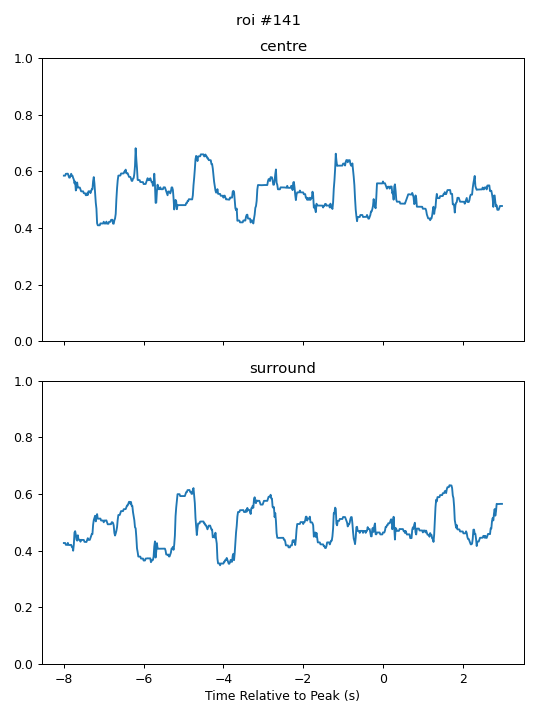

In [34]:
# centre_t = 6
# centre_b = 10
# centre_l = 3
# centre_r = 13
centre_t = 7
centre_b = 9
centre_l = 5
centre_r = 11
centre_mask = np.zeros((noise_cols, noise_rows), dtype=int)
centre_mask[centre_t:centre_b, centre_l:centre_r] = 1
surround_mask = np.ones((noise_cols, noise_rows), dtype=int) - centre_mask
print("centre mask:\n", centre_mask)

lead_stacks_flat = lead_stacks.reshape(n_kept_rois, n_trials, lead_frames, -1)
centre_beams = np.mean(lead_stacks_flat[:, :, :, centre_mask.reshape(-1)], axis=3)
surround_beams = np.mean(lead_stacks_flat[:, :, :, surround_mask.reshape(-1)], axis=3)

centre_surround_plotter = MultiWavePlotter(
#     [centre_beams, surround_beams],
    [np.mean(centre_beams, axis=1, keepdims=True), np.mean(surround_beams, axis=1, keepdims=True)],
    xaxis=lead_xaxis,
    ymin=0,
    ymax=1,
    title_fmt_fun=lambda i: "centre" if not i else "surround",
    idx_fmt_fun=lambda i: "roi #%i" % pos_to_roi[i],
    figsize=(6, 8),
    sharex=True,
)
centre_surround_plotter.ax[1].set_xlabel("Time Relative to Peak (s)")
centre_surround_plotter.fig.tight_layout()

### Average of all centre-surrounds

<IPython.core.display.Javascript object>


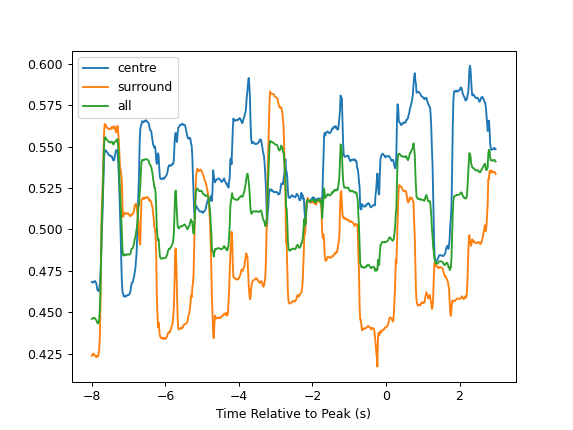

(224, 3, 660, 16, 16)


In [35]:
avg_centre_beam = np.mean(centre_beams, axis=(0, 1))
avg_surround_beam = np.mean(surround_beams, axis=(0, 1))
avg_all_beam = np.mean([avg_centre_beam, avg_surround_beam], axis=0)
avg_centre_surround_fig, avg_centre_surround_ax = plt.subplots(1)
avg_centre_surround_ax.plot(lead_xaxis, avg_centre_beam, label="centre")
avg_centre_surround_ax.plot(lead_xaxis, avg_surround_beam, label="surround")
avg_centre_surround_ax.plot(lead_xaxis, avg_all_beam, label="all")
avg_centre_surround_ax.set_xlabel("Time Relative to Peak (s)")
avg_centre_surround_ax.legend()
print(lead_stacks.shape)

### Randomly triggered stimulus for comparison

Sampling N windows from the stimulus randomly, where N is the number of peaks found in the target ROI above (trial with lowest number of legal peaks is used). This is presented for comparison to get a feel for how variable the averages are with this number of samples, as well as to see how often "receptive field" like signals emerge by chance. 

(3, 420, 16, 16)
(420,)


<IPython.core.display.Javascript object>


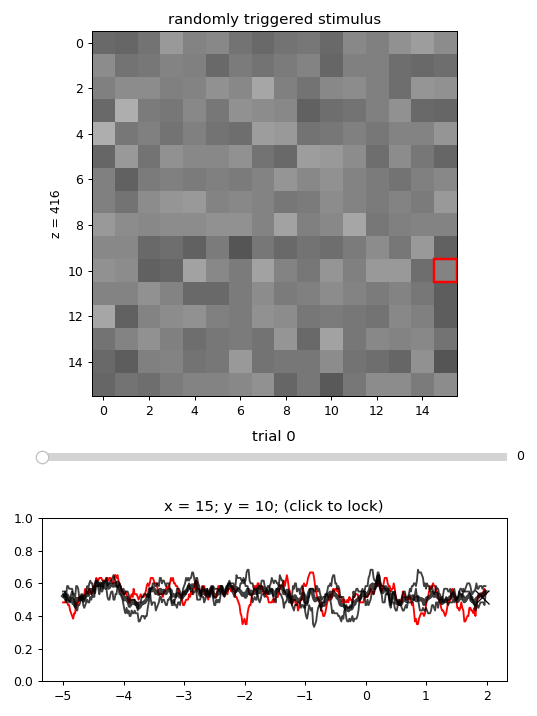

In [30]:
random_lead_stack = np.stack([
    np.mean([
        lead_window(noise_xaxis, raw_noise, t + post, lead + post)
        for t in np.random.uniform(
            low=(np.min(noise_xaxis) + lead), 
            high=np.max(noise_xaxis) - post,
            size=n
        )
    ], axis=0)
#     for n in n_legals
    for n in [60, 60, 60]
], axis=0)

print(random_lead_stack.shape)
print(lead_xaxis.shape)
random_lead_stack_plot = StackExplorer(
    random_lead_stack,
    zaxis=lead_xaxis,
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
random_lead_stack_plot.ax[0].set_title("randomly triggered stimulus")
random_lead_stack_plot.ax[1].set_xlabel("Time Relative to Peak (s)")
random_lead_stack_plot.fig.tight_layout()

### Average of all ROI Triggered Movies
This is done to see whether any clear pattern emerges with respect to receptive fields. Since the noise stimulus is quite large relative to the imaged bipolar terminals, we might expect to see a bias of surround-like kernels out from the middle. Or perhaps an average centre like kernel in the middle, if we expect the receptive fields of the bipolar cells to overlap somewhat.

<IPython.core.display.Javascript object>


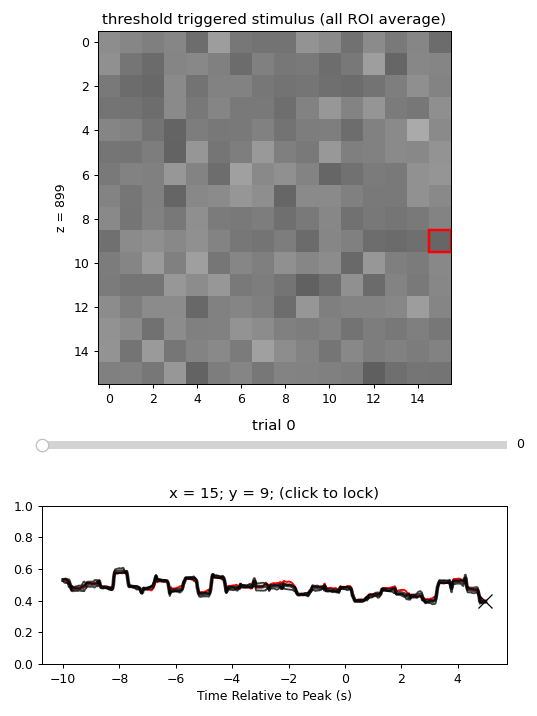

In [46]:
roi_avg_lead_stack_plot = StackExplorer(
    all_roi_lead_stack,
    zaxis=lead_xaxis,
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
roi_avg_lead_stack_plot.stack_ax.set_title("threshold triggered stimulus (all ROI average)")
roi_avg_lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
roi_avg_lead_stack_plot.fig.tight_layout()

### Principle component analysis and kmeans clustering of all temporal beams pulled from the response triggered noise stimuli for all ROIs

<IPython.core.display.Javascript object>


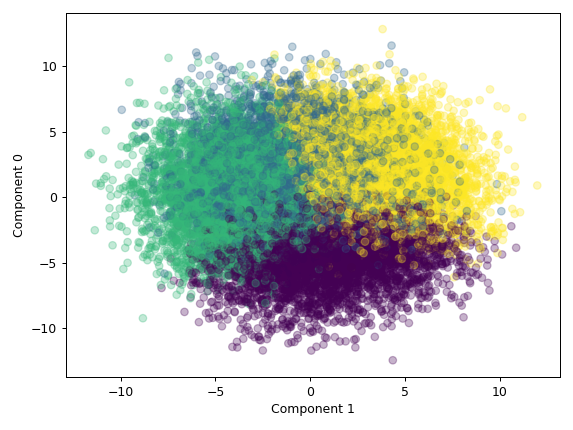

pca_k_lbls shape: (95, 16, 16)
kmeans groups: [5783, 6118, 6263, 6156]
soft groups: [6113, 6290, 5879, 6038]


In [24]:
pca = PCA()
k = 4
start_frame = 0
end_frame = lead_frames
# start_frame = nearest_index(lead_xaxis, -1)
# end_frame = nearest_index(lead_xaxis, 0.)

trunc_mean_lead_stacks = mean_lead_stacks[:, start_frame:end_frame]
x = trunc_mean_lead_stacks.transpose(1, 0, 2, 3).reshape(
    trunc_mean_lead_stacks.shape[1], -1
).T

x_mean = np.mean(x, axis=0)
x_std = np.std(x, axis=0)

# trial normalized
# norm_x = (x - x_mean) / x_std

# per beam mean subtracted
# norm_x = x - np.mean(x, axis=1, keepdims=True)

# per beam normalized
norm_x = (x - np.mean(x, axis=1, keepdims=True)) / np.std(x, axis=1, keepdims=True)

reduced_trig_avg = pca.fit_transform(norm_x)[:, :10]
pca_k_centres, pca_k_lbls_flat, pca_k_error = cluster.k_means(reduced_trig_avg, k)
pca_k_distances_flat = np.stack(
    [np.abs(reduced_trig_avg - c.reshape(1, -1)).sum(axis=1) for c in pca_k_centres],
    axis=0
)
pca_k_probs_flat = soft_min(pca_k_distances_flat)
pca_k_distances = pca_k_distances_flat.reshape(k, n_kept_rois, noise_cols, noise_rows)
pca_k_probs = pca_k_probs_flat.reshape(k, n_kept_rois, noise_cols, noise_rows)

soft_pca_centres, soft_pca_clusters_flat, _ = clorch.soft_kmeans(
    torch.from_numpy(reduced_trig_avg), k)
soft_pca_centres = soft_pca_centres.cpu().numpy()
soft_pca_clusters_flat = soft_pca_clusters_flat.cpu().numpy()
soft_pca_lbls_flat = np.argmax(soft_pca_clusters_flat, axis=1)
soft_pca_clusters = soft_pca_clusters_flat.reshape(
    n_kept_rois, noise_cols, noise_rows, -1
)
soft_pca_lbls = soft_pca_lbls_flat.reshape(
    n_kept_rois, noise_cols, noise_rows
)

pca_trig_fig, pca_trig_ax = plt.subplots(1)
pca_trig_ax.scatter(
    reduced_trig_avg[:, 0],
    reduced_trig_avg[:, 1],
    alpha=.3,
    c=pca_k_lbls_flat,
)

pca_trig_ax.set_ylabel("Component 0")
pca_trig_ax.set_xlabel("Component 1")
pca_trig_fig.tight_layout()

pca_k_lbls = pca_k_lbls_flat.reshape(
    n_kept_rois, noise_cols, noise_rows
)
print("pca_k_lbls shape:", pca_k_lbls.shape)
print("kmeans groups:", [np.sum(pca_k_lbls == i) for i in range(k)])
print("soft groups:", [np.sum(soft_pca_lbls == i) for i in range(k)])

<IPython.core.display.Javascript object>


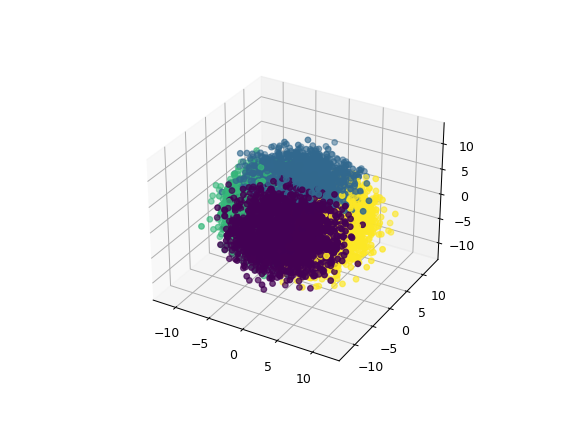

In [25]:
pca_3d_trig_fig = plt.figure()
pca_3d_trig_ax = pca_3d_trig_fig.add_subplot(111, projection='3d')

pca_3d_trig_ax.scatter(
    reduced_trig_avg[:, 0],
    reduced_trig_avg[:, 1],
    reduced_trig_avg[:, 2],
    c=pca_k_lbls_flat,
)

### Temporal kernel prototypes based on cluster assignments
Noise kernel beams across all ROIs are averaged together based on their cluster assignments. This is done in a few ways to assess whether there is much difference between using the hard assignments given by running kmeans, and weighted averaging based on distances between individual beams and the cluster centroids. 

<IPython.core.display.Javascript object>


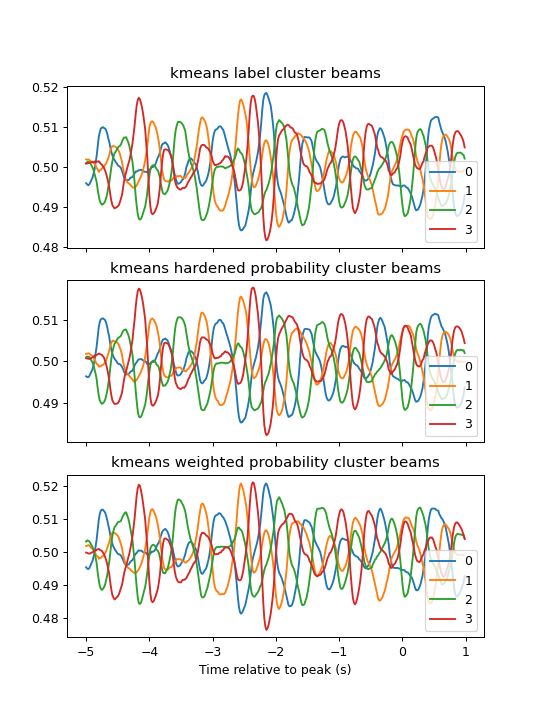

Text(0.5, 0, 'Time relative to peak (s)')

In [26]:
trans_mean_leads = mean_lead_stacks.transpose(0, 2, 3, 1)
label_cluster_beams = np.stack(
    [
        np.mean(trans_mean_leads[pca_k_lbls == i], axis=0) 
         for i in range(k)
    ],
    axis=0
)
hardened_prob_cluster_beams = np.stack(
    [
        np.mean(trans_mean_leads[np.argmax(pca_k_probs, axis=0) == i], axis=0) 
         for i in range(k)
    ],
    axis=0
)
weighted_prob_cluster_beams = (
#     pca_k_probs_flat @ norm_x.reshape(-1, lead_frames)
    pca_k_probs_flat @ norm_x.reshape(-1, end_frame - start_frame)
) / (noise_cols * noise_rows * n_kept_rois / 4) * x_std + x_mean


cluster_beams_fig, cluster_beams_ax = plt.subplots(3, figsize=(6, 8), sharex=True)
for i, (s, h, w) in enumerate(zip(
    label_cluster_beams,
    hardened_prob_cluster_beams, 
    weighted_prob_cluster_beams
)):
    cluster_beams_ax[0].plot(lead_xaxis, s, label="%i" % i)
    cluster_beams_ax[1].plot(lead_xaxis, h, label="%i" % i)
    cluster_beams_ax[2].plot(lead_xaxis[start_frame:end_frame], w, label="%i" % i)

for a in cluster_beams_ax:
    a.legend()

cluster_beams_ax[0].set_title("kmeans label cluster beams")
cluster_beams_ax[1].set_title("kmeans hardened probability cluster beams")
cluster_beams_ax[2].set_title("kmeans weighted probability cluster beams")
cluster_beams_ax[2].set_xlabel("Time relative to peak (s)")

### Map of assigned cluster labels over space
Use mouse scroll to cycle through ROIs.

<IPython.core.display.Javascript object>


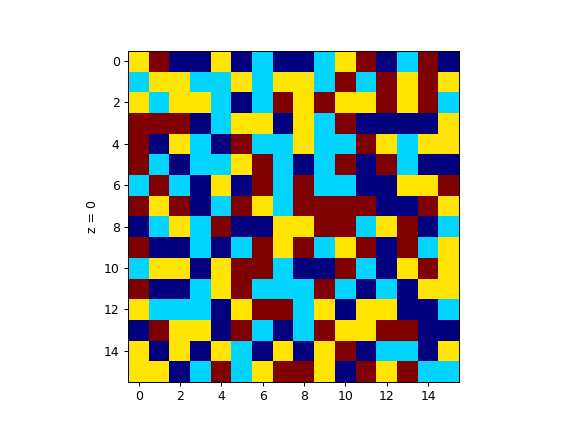

In [27]:
pca_group_map_fig, pca_group_map_ax = plt.subplots(1)
pca_group_map_plot = StackPlotter(
    pca_group_map_fig,
    pca_group_map_ax,
    pca_k_lbls,
    delta=1,
    cmap="jet"
)
pca_group_map_fig.show()

### Map of cluster assignment probabilities (based on distance from centroids)
The absolute distance of each kernel/beam of the triggered noise from the cluster centroids is calculated then ran through softmin to arrive at assignment probabilites (summing to 1) across each of the clusters. Use mouse scroll to cycle through ROIs.

<IPython.core.display.Javascript object>


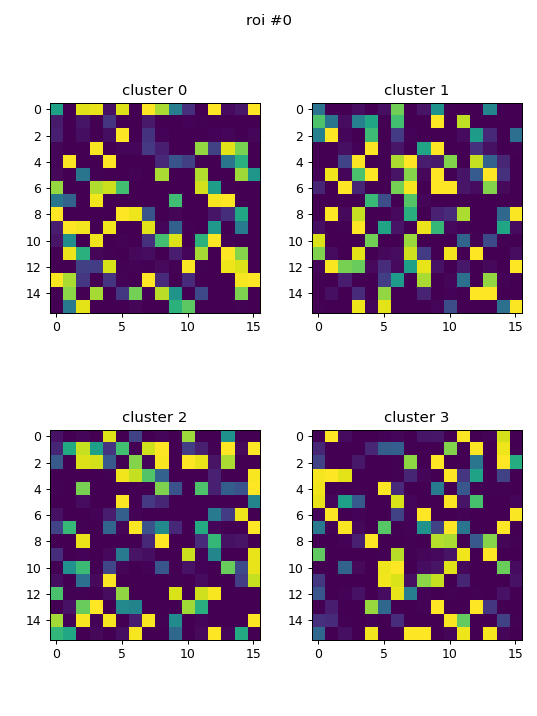

In [28]:
pca_prob_plotter = MultiStackPlotter(
    pca_k_probs,
    vmin=0,
    vmax=1,
    cmap="viridis",
    title_fmt_fun=lambda i: "cluster %i" % i,
    idx_fmt_fun=lambda i: "roi #%i" % pos_to_roi[i],
    figsize=(6, 8)
)
pca_prob_plotter.fig.tight_layout()

### Average of triggered kernel cluster probabilities across all ROIs
This is see whether a pattern emerges in the general locations of the temporal noise kernels that emerge from clustering.

<IPython.core.display.Javascript object>


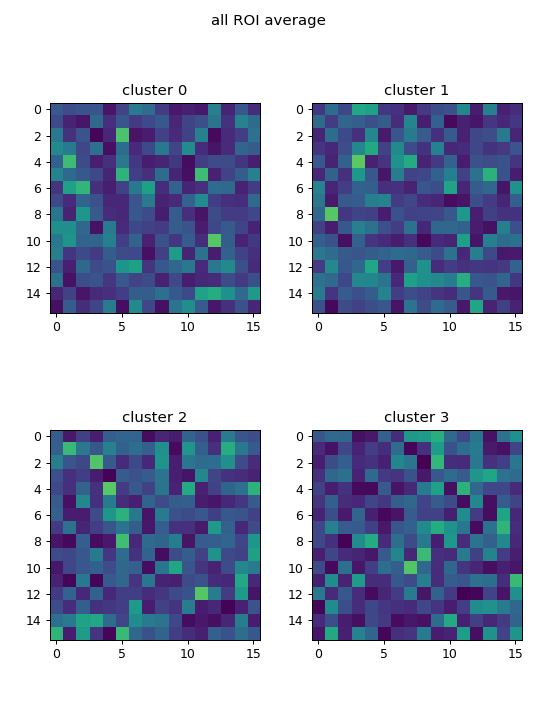

In [29]:
roi_avg_pca_prob_plotter = MultiStackPlotter(
    np.mean(pca_k_probs, axis=1, keepdims=True),
    vmin=0,
    vmax=1,
    cmap="viridis",
    title_fmt_fun=lambda i: "cluster %i" % i,
    idx_fmt_fun=lambda _: "all ROI average",
    figsize=(6, 8)
)
roi_avg_pca_prob_plotter.fig.tight_layout()

### Frequency analysis

Fourier analysis etc of triggered stimulus noise kernel beams to determine the frequency of the oscillations observered and also whether any spatial patters emerge.

<IPython.core.display.Javascript object>


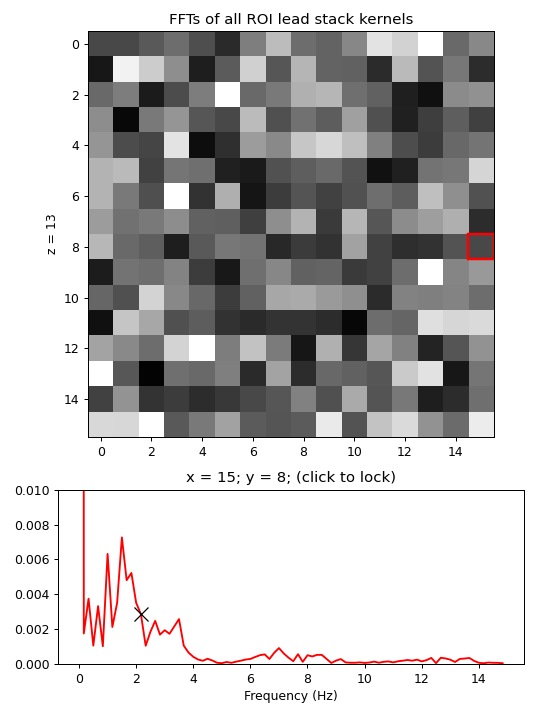

In [30]:
mean_all_roi_lead_stack = np.mean(all_roi_lead_stack, axis=0)
noise_dt = (np.max(noise_xaxis) - np.min(noise_xaxis)) / noise_xaxis.size
lead_fft_xaxis = np.fft.fftfreq(lead_frames, noise_dt)

mean_all_roi_lead_fft = np.stack([
    np.fft.fft(beam) for beam in mean_all_roi_lead_stack.reshape(lead_frames, -1).T
], axis=1) 
mean_all_roi_lead_fft = (
    2.0 / lead_frames * np.abs(mean_all_roi_lead_fft)
).reshape(lead_frames, noise_rows, noise_cols)

# clipping yaxis with vmax to be able to see the frequencies after the first, which
# accounts for the vast majority of the value
mean_all_roi_fft_plot = StackExplorer(
    mean_all_roi_lead_fft[:lead_frames // 4],
    zaxis=lead_fft_xaxis[:lead_frames // 4],
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=.01,
    figsize=(6, 8)
)
mean_all_roi_fft_plot.stack_ax.set_title("FFTs of all ROI lead stack kernels")
mean_all_roi_fft_plot.beam_ax.set_xlabel("Frequency (Hz)")
mean_all_roi_fft_plot.fig.tight_layout()

### Fourier of the pooled ROI trial averaged GluSnfr recording.
Only the time during the stimulus is used here.

/tmp/ipykernel_5967/2062128090.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  all_roi_rec_fft_fig, all_roi_rec_fft_ax = plt.subplots(1)


<IPython.core.display.Javascript object>


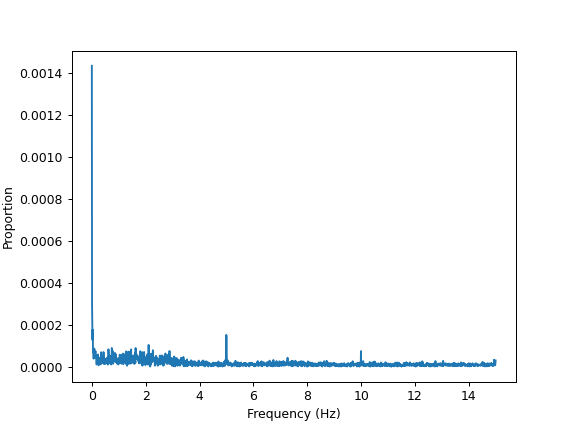

In [31]:
recs_dt = (np.max(recs_xaxis) - np.min(recs_xaxis)) / recs_xaxis.size
resp_pts = stim_end_idx - stim_start_idx
rec_fft_xaxis = np.fft.fftfreq(resp_pts, recs_dt)
freq_end_idx = nearest_index(rec_fft_xaxis, 15)  # last frequency to plot

all_roi_rec_fft = np.fft.fft(np.mean(avg_recs[:, stim_start_idx:stim_end_idx], axis=0))
all_roi_rec_fft = 2.0 / resp_pts * np.abs(all_roi_rec_fft)

all_roi_rec_fft_fig, all_roi_rec_fft_ax = plt.subplots(1)
all_roi_rec_fft_ax.plot(
    rec_fft_xaxis[:freq_end_idx],
    all_roi_rec_fft[:freq_end_idx],
)

all_roi_rec_fft_ax.set_ylabel("Proportion")
all_roi_rec_fft_ax.set_xlabel("Frequency (Hz)")
all_roi_rec_fft_fig.show()

### Inter-peak interval analysis
From the peak times used to calculate the triggered stimulus movies, calculate all of the event intervals.

mean interval:  0.719
median interval  0.567


<IPython.core.display.Javascript object>


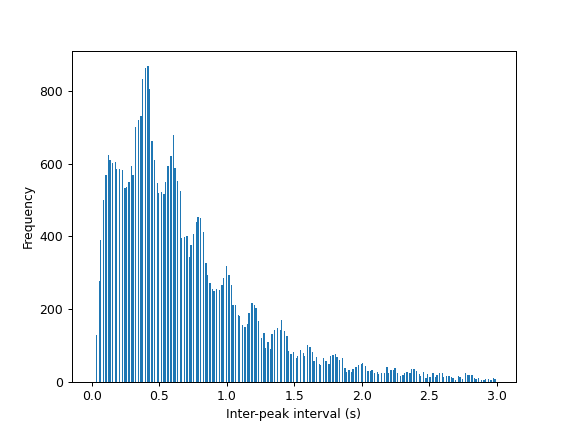

In [32]:
intervals = np.concatenate([
    ts[1:] - ts[:-1] for roi_ts in legal_times for ts in roi_ts
])

print("mean interval: % .3f" % np.mean(intervals))
print("median interval % .3f" % np.median(intervals))

bins = np.arange(300) * .01
# bins = np.linspace(0, 6, 6 * 50)

inter_hist_fig, inter_hist_ax = plt.subplots(1)
inter_hist_ax.hist(intervals, bins=bins)
inter_hist_ax.set_xlabel("Inter-peak interval (s)")
inter_hist_ax.set_ylabel("Frequency")
inter_hist_fig.show()

### Further clustering analysis, but experimenting with Deep ANNs (arficial neural networks)

In [63]:
def model_loader(model, pth):
    """Helper (more of a placeholder/reminder) dealing with loss.centres not being
    dealt with appropriately in model loading (centres attribute in whatever custom loss
    module is in use by the deep clustering autoencoder). Also, remember that the model
    that loads the dict has to be the same, so I shouldn't change ae_build's, and instead
    make new ones as needed."""
    d = torch.load(pth)
    del d["loss.centres"]
    return model.load_state_dict(d)


def ae_build_1():
    """
    256 frames -> 32 final kernel.
    """
    autoencoder = Conv1dDeepClusterer([
        {
            'type': 'conv', 'in': 1, 'out': 64, 'kernel': 11, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 64, 'out': 128, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 128, 'out': 256, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 256, 'out': 128, 'kernel': 16, 'stride': 1,
            'pad': 'valid'
        },
        {'type': 'squeeze'},
        {'type': 'dense', 'in': 128, 'out': 12},
    ])
    return "b1", autoencoder


def ae_build_2():
    """"""
    autoencoder = Conv1dDeepClusterer([
        {
            'type': 'conv', 'in': 1, 'out': 128, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 128, 'out': 256, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 256, 'out': 128, 'kernel': 18, 'stride': 1,
            'pad': 'valid'
        },
        {'type': 'squeeze'},
        {'type': 'dense', 'in': 128, 'out': 12},
    ])
    return "b2", autoencoder


def ae_build_3():
    """"""
    autoencoder = Conv1dDeepClusterer([
        {
            'type': 'conv', 'in': 1, 'out': 64, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 64, 'out': 128, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 128, 'out': 64, 'kernel': 18, 'stride': 1,
            'pad': 'valid'
        },
        {'type': 'squeeze'},
        {'type': 'dense', 'in': 64, 'out': 6},
    ])
    return "b3", autoencoder


def ae_build_4():
    """No convolutional layers, just a plain dense network."""
    autoencoder = Conv1dDeepClusterer([
        {'type': 'squeeze'},
        {'type': 'dense', 'in': 72, 'out': 512},
        {'type': 'dense', 'in': 512, 'out': 1024},
        {'type': 'dense', 'in': 1024, 'out': 10},
    ])
    return "b4", autoencoder

epoch: 0 n_batches: 32
cost: 0.500865
cost: 0.219847
epoch: 1 n_batches: 32
cost: 0.216225
cost: 0.189344
epoch: 2 n_batches: 32
cost: 0.193538
cost: 0.185197
epoch: 3 n_batches: 32
cost: 0.187811
cost: 0.179678
epoch: 4 n_batches: 32
cost: 0.176403
cost: 0.178739
epoch: 5 n_batches: 32
cost: 0.174592
cost: 0.173766
epoch: 6 n_batches: 32
cost: 0.169035
cost: 0.165189
epoch: 7 n_batches: 32
cost: 0.168051
cost: 0.161476
epoch: 8 n_batches: 32
cost: 0.161935
cost: 0.164957
epoch: 9 n_batches: 32
cost: 0.161142
cost: 0.158092
epoch: 10 n_batches: 32
cost: 0.160518
cost: 0.158343
epoch: 11 n_batches: 32
cost: 0.156632
cost: 0.158733
epoch: 12 n_batches: 32
cost: 0.160174
cost: 0.160660
epoch: 13 n_batches: 32
cost: 0.154564
cost: 0.158041
epoch: 14 n_batches: 32
cost: 0.155496
cost: 0.155362


<IPython.core.display.Javascript object>


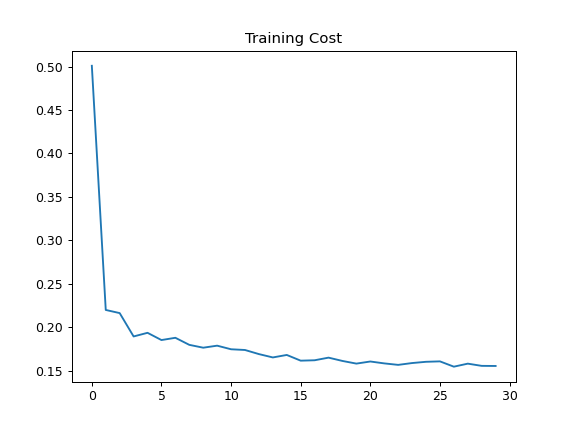

In [73]:
# build network
build_name, autoencoder = ae_build_1()

x = mean_lead_stacks.transpose(1, 0, 2, 3).reshape(
    lead_frames, 1, -1
).transpose(2, 1, 0)

# x = (x - np.mean(x, axis=(0, 1))) / np.std(x, axis=(0, 1))  # norm across beams
# x = x - np.mean(x, axis=2, keepdims=True)  # mean subtraction (within beam)
x = (x - np.mean(x, axis=2, keepdims=True)) / np.std(x, axis=2, keepdims=True)
x = x[:, :, 44:]  # cut down to 256 for clean divisibility and reconstruction 
x = x[:, :, 128:]  # cut down to 128 (testing) 

# fit network
cost_fig = autoencoder.fit(
    x,
    k, 
    lr=1e-3,
    epochs=15,
    batch_sz=512,
    cluster_alpha=0.2,
    var_cluster_frac=False,
    clust_mode='KLdiv',
#     clust_mode='Km',
    show_plot=True,
)

In [74]:
torch_reduced = autoencoder.get_reduced(x)

hard_centres, hard_clusters, _ = clorch.hard_kmeans(
    torch.from_numpy(torch_reduced), k)
hard_centres = hard_centres.cpu().numpy()
hard_clusters_flat = hard_clusters.cpu().numpy()
hard_clusters = hard_clusters_flat.reshape(
    n_kept_rois, noise_cols, noise_rows
)
hard_distances_flat = np.stack(
    [np.abs(torch_reduced - c.reshape(1, -1)).sum(axis=1) for c in hard_centres],
    axis=0
)
hard_probs_flat = soft_min(hard_distances_flat)
hard_distances = hard_distances_flat.reshape(k, n_kept_rois, noise_cols, noise_rows)
hard_probs = hard_probs_flat.reshape(k, n_kept_rois, noise_cols, noise_rows)
print(
    "hard torch groups:", 
    [np.sum(hard_clusters_flat == i) for i in range(k)]
)

soft_centres, soft_clusters, _ = clorch.soft_kmeans(
    torch.from_numpy(torch_reduced), k)
soft_centres = soft_centres.cpu().numpy()
soft_clusters_flat = soft_clusters.cpu().numpy()
soft_labels_flat = np.argmax(soft_clusters_flat, axis=1)
soft_clusters = soft_clusters_flat.reshape(
    n_kept_rois, noise_cols, noise_rows, -1
)
soft_labels = soft_labels_flat.reshape(
    n_kept_rois, noise_cols, noise_rows
)
print(
    "soft torch groups:", 
    [np.sum(soft_labels_flat == i) for i in range(k)]
)

hard torch groups: [5560, 5408, 5672]
soft torch groups: [5348, 5568, 5724]


<IPython.core.display.Javascript object>


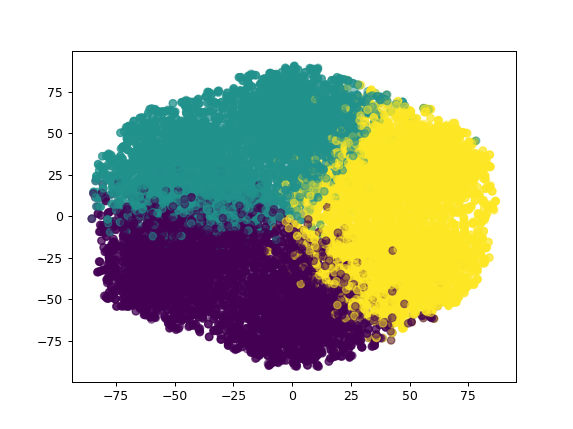

In [75]:
if torch_reduced.shape[1] > 2:
    # also, reduce the cluster centres (TSNE must do all at once)
    reduced_centres = TSNE(
        n_components=2, 
        perplexity=10, 
    ).fit_transform(
        np.concatenate([torch_reduced, hard_centres], axis=0)
    )
    # split samples and centres
    tsne_reduced = reduced_centres[:-hard_centres.shape[0], :]
    tsne_centres = reduced_centres[-hard_centres.shape[0]:, :]
    del reduced_centres

torch_reduced_fig, torch_reduced_ax = plt.subplots(1)

torch_reduced_ax.scatter(
    tsne_reduced[:, 0], 
    tsne_reduced[:, 1], 
    c=hard_clusters, 
    alpha=.5
)

<IPython.core.display.Javascript object>


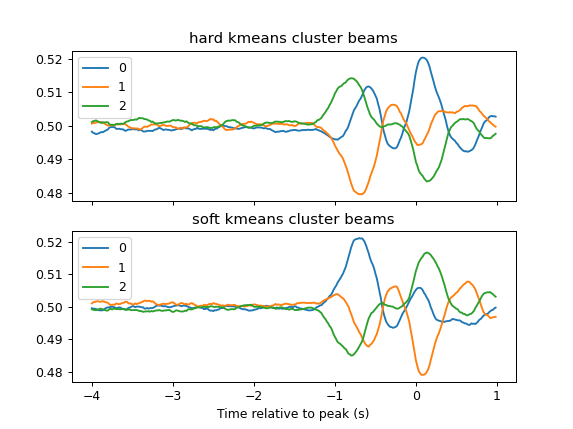

Text(0.5, 0, 'Time relative to peak (s)')

In [76]:
hard_cluster_beams = [
    np.mean(trans_mean_leads[hard_clusters == i], axis=0) 
    for i in range(k)
]
soft_cluster_beams = [
    np.mean(trans_mean_leads[soft_labels == i], axis=0) 
    for i in range(k)
]

torch_beams_fig, torch_beams_ax = plt.subplots(2, sharex=True)
for i, (hb, sb) in enumerate(zip(hard_cluster_beams, soft_cluster_beams)):
    torch_beams_ax[0].plot(lead_xaxis, hb, label="%i" % i)
    torch_beams_ax[1].plot(lead_xaxis, sb, label="%i" % i)

for a in torch_beams_ax:
    a.legend()
    
torch_beams_ax[0].set_title("hard kmeans cluster beams")
torch_beams_ax[1].set_title("soft kmeans cluster beams")
torch_beams_ax[1].set_xlabel("Time relative to peak (s)")

### Map of assigned cluster labels over space
Use mouse scroll to cycle through ROIs.

<IPython.core.display.Javascript object>


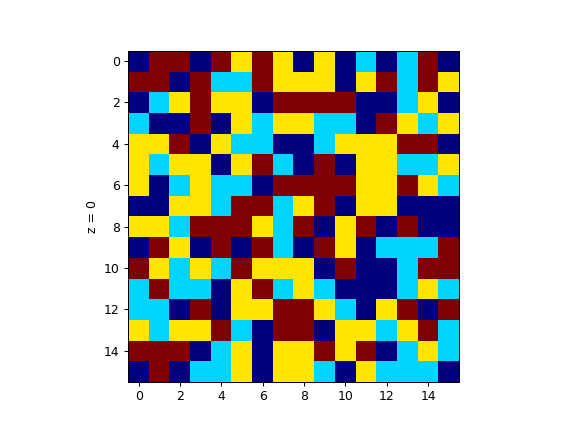

In [63]:
hard_clust_map_fig, hard_clust_map_ax = plt.subplots(1)
hard_clust_map_plot = StackPlotter(
    hard_clust_map_fig,
    hard_clust_map_ax,
    hard_clusters,
    delta=1,
    cmap="jet"
)
hard_clust_map_fig.show()

### Map of cluster assignment probabilities (based on distance from centroids)
The absolute distance of each kernel/beam of the triggered noise from the cluster centroids is calculated then ran through softmin to arrive at assignment probabilites (summing to 1) across each of the clusters. Use mouse scroll to cycle through ROIs.

<IPython.core.display.Javascript object>


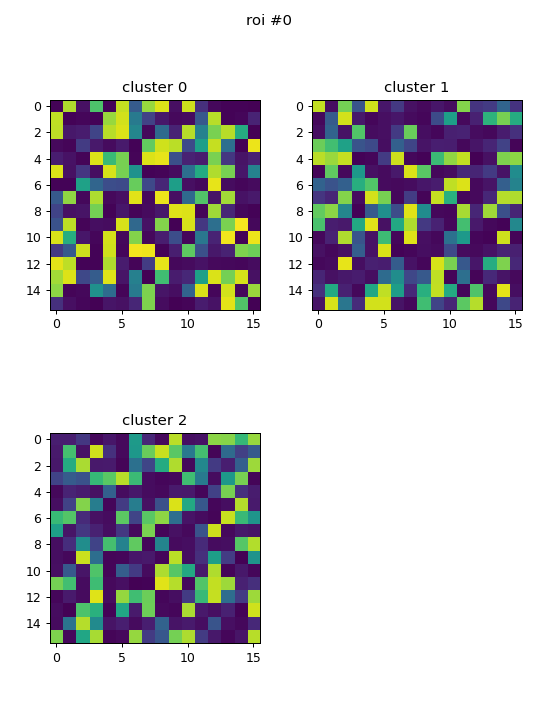

In [77]:
hard_prob_plotter = MultiStackPlotter(
    hard_probs,
    vmin=0,
    vmax=1,
    cmap="viridis",
    title_fmt_fun=lambda i: "cluster %i" % i,
    idx_fmt_fun=lambda i: "roi #%i" % pos_to_roi[i],
    figsize=(6, 8)
)
hard_prob_plotter.fig.tight_layout()

In [ ]:
if 0:
    model_folder = "models"
    os.makedirs(model_folder, exist_ok=True)
    base_name = "noise_ae"
    tag = ""
    date_string = date.today().strftime("%Y_%m_%d")
    full_name = "%s_%s_%s_%s_v" % (base_name, build_name, tag, date_string)
    i = 0
    while True:
        model_path = os.path.join(model_folder, "%s%i.state" % (full_name, i))
        if os.path.exists(model_path):
            i += 1
        else:
            break
    torch.save(autoencoder.state_dict(), model_path)

In [12]:
def add(a, b):
    return a + b

add(*([1] * (8 - 5)))

TypeError: add() takes 2 positional arguments but 3 were given

In [18]:
1 / ((noise_xaxis.max() - noise_xaxis.min()) / (len(noise_xaxis) - 1))

59.999999999999986

In [16]:
1 / (noise_xaxis.max() / len(noise_xaxis))

55.39171688678036

In [17]:
lead_frames

300